<a href="https://colab.research.google.com/github/gaixen/Codes-from-scratch/blob/main/RNN%20and%20LSTM/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
from tqdm.notebook import tqdm as tqdm
import numpy as np

In [110]:
data = """To be, or not to be, that is the question: Whether \
'tis nobler in the mind to suffer The slings and arrows of ou\
trageous fortune, Or to take arms against a sea of troubles A\
nd by opposing end them. To die—to sleep, No more; and by a s\
leep to say we end The heart-ache and the thousand natural sh\
ocks That flesh is heir to: 'tis a consummation Devoutly to b\
e wish'd. To die, to sleep; To sleep, perchance to dream—ay, \
there's the rub: For in that sleep of death what dreams may c\
ome, When we have shuffled off this mortal coil, Must give us\
 pause—there's the respect That makes calamity of so long lif\
e. For who would bear the whips and scorns of time, Th'oppres\
sor's wrong, the proud man's contumely, The pangs of dispriz'\
d love, the law's delay, The insolence of office, and the spu\
rns That patient merit of th'unworthy takes, When he himself \
might his quietus make""".lower()


In [111]:
chars = set(data)
data_size , char_size = len(data) , len(chars)
char_to_idx = {char : i for i , char in enumerate(chars)}
idx_to_char = {i : char for i , char in enumerate(chars)}

train_x = data[:-1]
train_y = data[1:]

In [112]:
def one_hot_encoding(text):
  output = np.zeros((char_size,1))
  output[char_to_idx[text]] = 1
  return output

def xavier_initialisation_weights(input_size , output_size):
  return np.random.uniform(-1, 1 ,(output_size,input_size))* np.sqrt(6/(input_size+output_size))

In [113]:
def tanh(input , derivative = False):
  if derivative:
    return 1-input**2
  return np.tanh(input)

def sigmoid(input , derivative = False):
  if derivative:
    return input*(1-input)
  return 1/(1+np.exp(-1*input))

def softmax(input):
  return np.exp(input)/np.sum(np.exp(input))


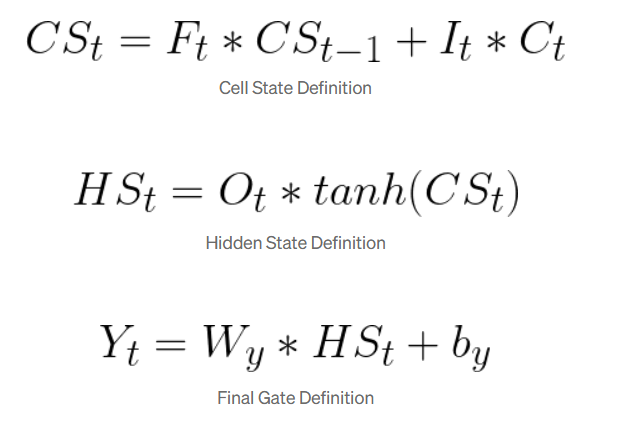

In [114]:
class LSTM():
  def __init__(self,input_size, hidden_size ,output_size , epochs , learning_rate):
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    self.epochs = epochs

    self.wf = xavier_initialisation_weights(input_size , hidden_size)
    self.bf = np.zeros((hidden_size,1))

    self.wi = xavier_initialisation_weights(input_size , hidden_size)
    self.bi = np.zeros((hidden_size,1))

    self.wc = xavier_initialisation_weights(input_size , hidden_size)
    self.bc = np.zeros((hidden_size,1))

    self.wo = xavier_initialisation_weights(input_size , hidden_size)
    self.bo = np.zeros((hidden_size,1))

    self.wy = xavier_initialisation_weights(hidden_size,output_size)
    self.by = np.zeros((output_size,1))

  def reset(self):
    self.concat_inputs = []
    self.cell_state = {-1:np.zeros((self.hidden_size,1))}
    self.hidden_state = {-1:np.zeros((self.hidden_size,1))}

    self.forget_gates = {}
    self.candidate_gates = {}
    self.input_gates = {}
    self.output_gates = {}
    self.output = {}
    self.activation_output = {}

  def feedforward(self , inputs):
    self.reset()
    outputs = []
    for q in range(len(inputs)):
      concat_inputs_q = np.concatenate((self.hidden_state[q-1],inputs[q]),axis=0)
      self.concat_inputs.append(concat_inputs_q)
      self.forget_gates[q] = sigmoid(np.dot(self.wf,self.concat_inputs[q])+self.bf)
      self.candidate_gates[q] = tanh(np.dot(self.wc , self.concat_inputs[q])+self.bc)
      self.input_gates[q] = sigmoid(np.dot(self.wi , self.concat_inputs[q])+self.bi)
      self.output_gates[q] = sigmoid(np.dot(self.wo , self.concat_inputs[q])+self.bo)

      self.cell_state[q] = self.forget_gates[q]*self.cell_state[q-1] + self.input_gates[q]*self.candidate_gates[q]
      self.hidden_state[q] = self.output_gates[q]* tanh(self.cell_state[q])

      outputs_q= np.dot(self.wy,self.hidden_state[q]) + self.by
      outputs.append(outputs_q)
    return outputs

  def backpropagation(self , errors , inputs):
    delta_wf , delta_bf = np.zeros_like(self.wf),np.zeros_like(self.bf)
    delta_wi , delta_bi = np.zeros_like(self.wi),np.zeros_like(self.bi)
    delta_wc , delta_bc = np.zeros_like(self.wc),np.zeros_like(self.bc)
    delta_wo , delta_bo = np.zeros_like(self.wo),np.zeros_like(self.bo)
    delta_wy , delta_by = np.zeros_like(self.wy),np.zeros_like(self.by)
    dh_next , dc_next = np.zeros_like(self.hidden_state[0]) , np.zeros_like(self.cell_state[0])

    for q in reversed(range(len(inputs))):
      error = errors[q]
      delta_wy += np.dot(error.reshape(-1,1),self.hidden_state[q].T)
      delta_by += error.reshape(-1,1)
      delta_hidden_state = np.dot(self.wy.T , error.reshape(-1,1)) + dh_next

      delta_o = tanh(self.cell_state[q])*delta_hidden_state*sigmoid(self.output_gates[q],derivative=True)
      delta_wo += np.dot(delta_o , inputs[q].T)
      delta_bo += delta_o

      delta_cell_state = tanh(tanh(self.cell_state[q]),derivative=True)*self.output_gates[q]*delta_hidden_state + dc_next

      delta_forget = delta_cell_state*self.cell_state[q-1]*sigmoid(self.forget_gates[q],derivative=True)
      delta_wf += np.dot(delta_forget , inputs[q].T)
      delta_bf += delta_forget

      delta_input = delta_cell_state*self.candidate_gates[q]*sigmoid(self.input_gates[q],derivative=True)
      delta_wi += np.dot(delta_input , inputs[q].T)
      delta_bi += delta_input

      delta_candidate = delta_cell_state*self.input_gates[q]*tanh(self.candidate_gates[q],derivative=True)
      delta_wc += np.dot(delta_candidate , inputs[q].T)
      delta_bc += delta_candidate

      delta_z = np.dot(self.wf.T , delta_forget)+np.dot(self.wi.T , delta_input)+np.dot(self.wc.T , delta_candidate)+np.dot(self.wo.T , delta_o)
      dh_next = delta_z[:self.hidden_size,:]
      dc_next = self.forget_gates[q]*delta_cell_state

    for d in (delta_wf,delta_bf,delta_wi,delta_bi,delta_wc,delta_bc,delta_wo,delta_bo,delta_wy,delta_by):
        np.clip(d,-1,1,out=d)

    self.wf -= delta_wf*self.learning_rate
    self.bf -= delta_bf*self.learning_rate

    self.wi -= delta_wi*self.learning_rate
    self.bi -= delta_bi*self.learning_rate

    self.wc -= delta_wc*self.learning_rate
    self.bc -= delta_bc*self.learning_rate

    self.wo -= delta_wo*self.learning_rate
    self.bo -= delta_bo*self.learning_rate

    self.wy -= delta_wy*self.learning_rate
    self.by -= delta_by*self.learning_rate

  def training(self , inputs , targets):
    inputs = [one_hot_encoding(input) for input in inputs]
    for i in tqdm(range(self.epochs)):
      predictions = self.feedforward(inputs)

      errors =[]
      for j in range(len(predictions)):
        error = -softmax(predictions[j].reshape(-1))
        terget_index = char_to_idx[targets[j]]
        error[terget_index] +=1
        errors.append(error)
      self.backpropagation(errors , inputs)

  def testing(self ,inputs,targets):
    accuracy = 0
    probabilitiess = self.feedforward([one_hot_encoding(input) for input in inputs])
    output =''
    for k in range(len(targets)):
      prediction = idx_to_char[np.random.choice([*range(char_size)],p = softmax(probabilitiess[k].reshape(-1)))]

      output +=prediction
      if prediction == targets[k]:
        accuracy += 1

    print(f'Ground Truth:\nt{targets}\n')
    print(f'Predictions:\nt{"".join(output)}\n')

    print(f'Accuracy: {round(accuracy * 100 / len(inputs), 2)}%')


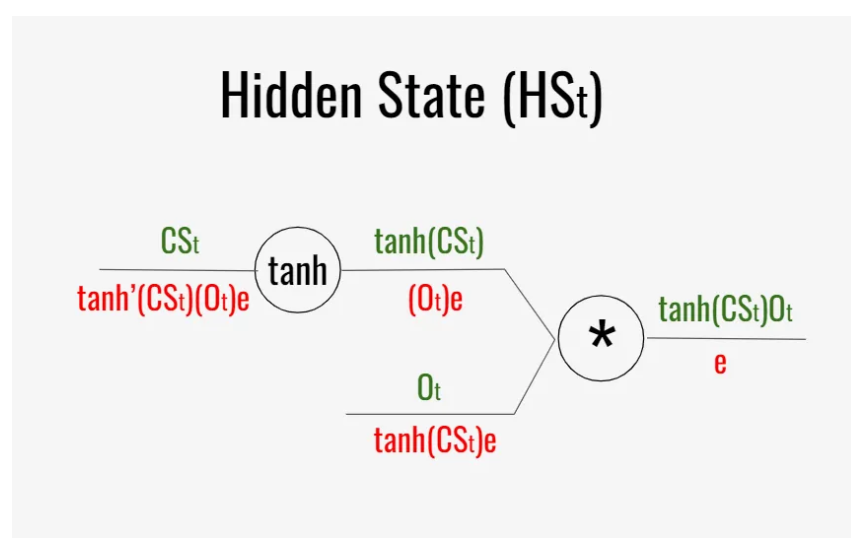

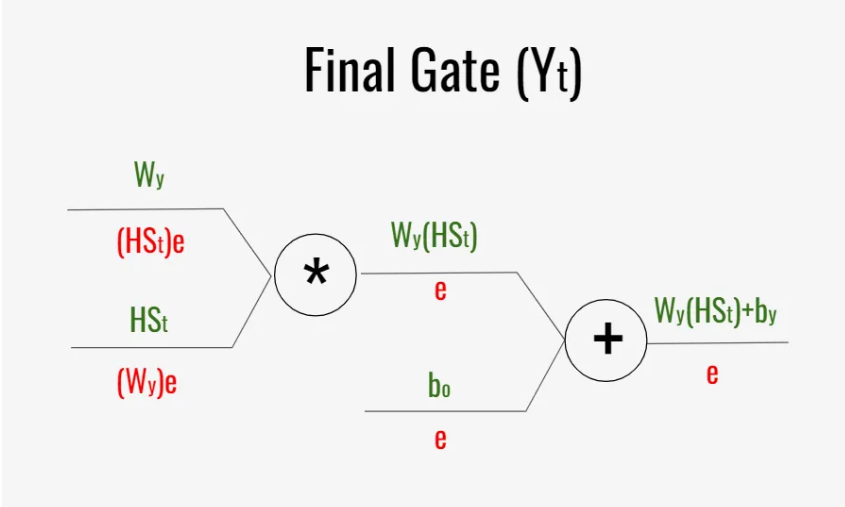

In [ ]:
hidden_size = 25
lstm = LSTM(input_size=char_size+hidden_size , hidden_size=hidden_size , output_size=char_size
            ,epochs = 1000,learning_rate=0.01)

lstm.training(train_x,train_y)
lstm.testing(train_x,train_y)
